In [1]:
# =====================
# CONFIG 
# =====================
from pathlib import Path
import numpy as np
import torch
# Imports
import sys, os, math
from tqdm import tqdm

# Move cwd up one level (from project_dir/jupyter -> project_dir)
ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
if os.getcwd() != "/mnt/nas_drive/psklavos/crexdata/MCLNF-FDA":
    os.chdir(ROOT)
    sys.path.insert(0, str(ROOT))

print("CWD set to:", os.getcwd())
from data.colmap_utils import read_points3D_binary
from data.dataset import get_image_metadata

DATA_PATH = "data/drz/out/new"  # e.g., "/data/out/partner_germany_site_01"
SCALE = .25            # 1.0 => original resolution
REGION_ID =1 
MASK_DIR = Path(DATA_PATH) / 'masks' /'g22_grid_bm110'/ str(REGION_ID)         # or a subdir name under DATA_PATH/masks
# Load metadata (train & val)


def compute_near_far_coverage(meta_list, points3D, device="cpu"):
    """
    For each ImageMetadata, compute what fraction of COLMAP 3D points
    lie within its [near, far] interval along the camera's forward (-z) axis.

    Args:
        meta_list : list[ImageMetadata]
        points3D  : dict[int, Point3D]  (as returned by read_points3D_binary)
        device    : "cpu" or "cuda"

    Returns:
        dict mapping image_index -> (coverage_fraction, median_depth, min_depth, max_depth)
    """
    # collect all 3D points (N,3)
    pts = np.stack([p.xyz for p in points3D.values()])
    pts_t = torch.as_tensor(pts, dtype=torch.float32, device=device)  # (N,3)

    results = {}

    for md in tqdm(meta_list, desc="Coverage check"):
        c2w = md.c2w.to(device).float()
        W, H = md.W, md.H
        near, far = md.near, md.far

        # camera-to-world -> world-to-camera
        R = c2w[:3, :3]
        t = c2w[:3, 3]

        # transform points into camera coordinates
        # X_cam = R^T * (X_world - t)
        Pw = pts_t - t[None, :]
        Pc = Pw @ R  # assuming R columns are world axes in c2w (standard COLMAP conv)

        # depth along camera -z (NeRF uses camera forward = -z)
        z = -Pc[:, 2]
        z = z[z > 0]  # only points in front of camera

        if z.numel() == 0:
            results[md.image_index] = (0.0, float("nan"), float("nan"), float("nan"))
            continue

        # fraction of depths inside the [near, far] range
        mask = (z >= near) & (z <= far)
        coverage = mask.float().mean().item()

        z_np = z.cpu().numpy()
        results[md.image_index] = (
            coverage,
            float(np.median(z_np)),
            float(z_np.min()),
            float(z_np.max()),
        )

    return results

# Sweep near/far quickly:
train_md, val_md = get_image_metadata(DATA_PATH, SCALE, mask_dir=MASK_DIR)
points = read_points3D_binary('data/drz/model/points3D.bin')

Point3DClass = type(next(iter(points.values())))  # get the class of the existing Point3D
origin_drb = np.array([-0.1021835, 0.39724215, 4.52259827])
pose_scale_factor = 227.437721

normalized_points = {}

for pid, p in points.items():
    new_xyz = (p.xyz - origin_drb) / pose_scale_factor
    normalized_points[pid] = Point3DClass(
        id=p.id,
        xyz=new_xyz,
        rgb=p.rgb,
        error=p.error,
        image_ids=p.image_ids,
        point2D_idxs=p.point2D_idxs
    )

# Now use the normalized dict
cov = compute_near_far_coverage(train_md, normalized_points, "cuda")



CWD set to: /mnt/nas_drive/psklavos/crexdata/MCLNF-FDA


Coverage check:   0%|          | 0/174 [00:00<?, ?it/s]


TypeError: '<=' not supported between instances of 'Tensor' and 'PosixPath'

In [20]:
import numpy as np
import pymap3d as pm

def normalize_points3D_full(points3D,
                            origin_drb, pose_scale_factor,
                            ecef_to_enu=True,
                            lat0=None, lon0=None, h0=None,
                            forward_is_north=False):
    """Normalize COLMAP 3D points to DRB coordinate frame (same as dataset)."""
    pts = np.stack([p.xyz for p in points3D.values()], axis=0)

    # optional: ECEF -> ENU
    if ecef_to_enu:
        ell = pm.Ellipsoid.from_name('wgs84')
        pts_enu = np.array([
            pm.ecef2enu(X, Y, Z, lat0, lon0, h0, ell=ell)
            for X, Y, Z in pts
        ])
    else:
        pts_enu = pts

    # ENU → DRB mapping
    z_sign = -1.0 if forward_is_north else 1.0
    pts_drb = np.stack([
        -pts_enu[:, 2],          # Down = -Up
         pts_enu[:, 0],          # Right = East
         z_sign * pts_enu[:, 1]  # Back = ±North
    ], axis=1)

    # normalize by dataset origin and scale
    pts_norm = (pts_drb - origin_drb[None, :]) / pose_scale_factor
    return pts_norm

def norm_helper_drz(points):
    origin_drb = np.array([-0.1021835, 0.39724215, 4.52259827])
    pose_scale_factor = 227.437721

    # these must match your dataset ENU origin (stored in prepare_dataset logs)
    lat0, lon0, h0 = 51.548867638888886, 7.372057555555555 ,233.26 # <-- fill from your log!
    return normalize_points3D_full(
        points, origin_drb, pose_scale_factor,
        ecef_to_enu=True, lat0=lat0, lon0=lon0, h0=h0,
        forward_is_north=True
    )

In [ ]:
# from your dataset summary

points_norm = norm_helper_drz(points)
cov = compute_near_far_coverage(train_md, points_norm, "cuda")

In [ ]:
N = 10
for i, (img_id, (cov, med, zmin, zmax)) in enumerate(cov.items()):
    if i >= N:
        break
    print(f"[{img_id:03d}] cov={cov:.3f}, median={med:.3f}, "
          f"depth range=[{zmin:.3f}, {zmax:.3f}]")


Loading COLMAP model…
Loaded 183037 3D points, 249 images.
origin_drb=[-0.1021835   0.39724216  4.52259827], pose_scale=227.437721
ENU origin (policy=mean): lat0=51.548993636, lon0=7.373026041, h0=232.993
AABB min=[ 2.77813322e-03 -3.63094683e+00 -3.64855588e+00], max=[3.78333489 1.53465654 1.74460475]
[img_id=2] meta near=0.366, far=0.443, depth min=0.000, max=0.383, median=0.146
 coverage=0.6% | below=99.4% | above=0.0% | p5=0.016 p20=0.057 p80=0.258 p95=0.326
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.016, far=0.371 | tmin=0.016, tmax=2.978, p1=0.004, p99=0.361


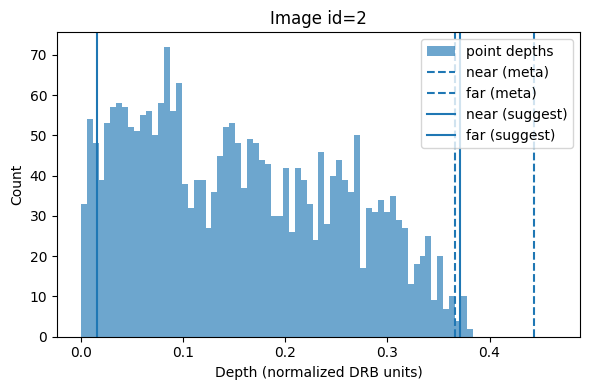

[rdf] p1=0.363 p2=0.366 p10=0.390 p90=0.441 p98=0.443 p99=0.444
[rdf near/far] 2/98 -> near=0.366, far=0.443
[rdf near/far] 10/90 -> near=0.390, far=0.441
[delta vs meta] |meta-2/98|: near=0.000e+00, far=0.000e+00
[delta vs meta] |meta-10/90|: near=2.338e-02, far=2.559e-03
[img_id=6] meta near=0.379, far=0.440, depth min=0.000, max=0.363, median=0.093
 coverage=0.0% | below=100.0% | above=0.0% | p5=0.011 p20=0.042 p80=0.162 p95=0.254
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.010, far=0.328 | tmin=0.010, tmax=2.999, p1=0.003, p99=0.318


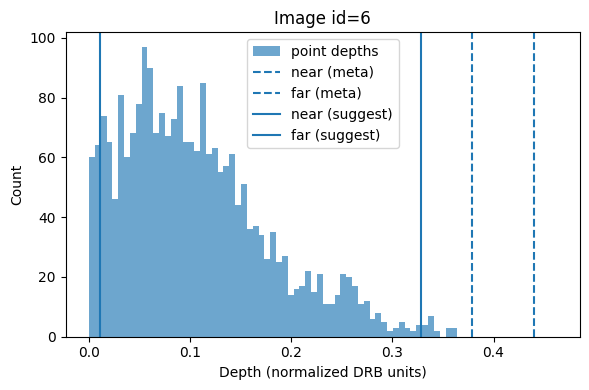

[rdf] p1=0.370 p2=0.379 p10=0.428 p90=0.438 p98=0.440 p99=0.441
[rdf near/far] 2/98 -> near=0.379, far=0.440
[rdf near/far] 10/90 -> near=0.428, far=0.438
[delta vs meta] |meta-2/98|: near=0.000e+00, far=0.000e+00
[delta vs meta] |meta-10/90|: near=4.934e-02, far=1.952e-03
[img_id=11] meta near=0.377, far=0.445, depth min=0.000, max=0.368, median=0.122
 coverage=0.0% | below=100.0% | above=0.0% | p5=0.021 p20=0.061 p80=0.214 p95=0.290
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.011, far=0.358 | tmin=0.011, tmax=3.008, p1=0.003, p99=0.348


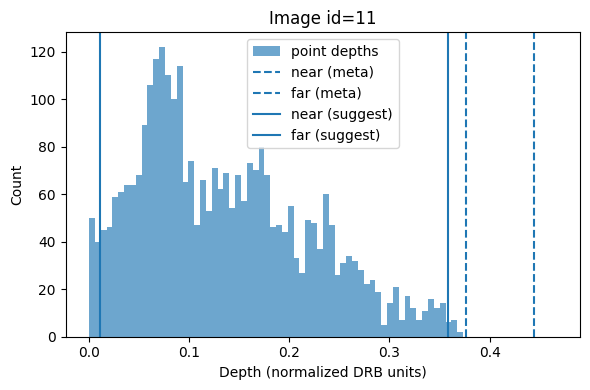

[rdf] p1=0.374 p2=0.377 p10=0.398 p90=0.439 p98=0.445 p99=0.448
[rdf near/far] 2/98 -> near=0.377, far=0.445
[rdf near/far] 10/90 -> near=0.398, far=0.439
[delta vs meta] |meta-2/98|: near=0.000e+00, far=0.000e+00
[delta vs meta] |meta-10/90|: near=2.123e-02, far=6.077e-03
[img_id=16] meta near=0.344, far=0.448, depth min=0.000, max=0.350, median=0.083
 coverage=0.5% | below=99.5% | above=0.0% | p5=0.009 p20=0.033 p80=0.176 p95=0.247
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.017, far=0.342 | tmin=0.017, tmax=2.872, p1=0.002, p99=0.332


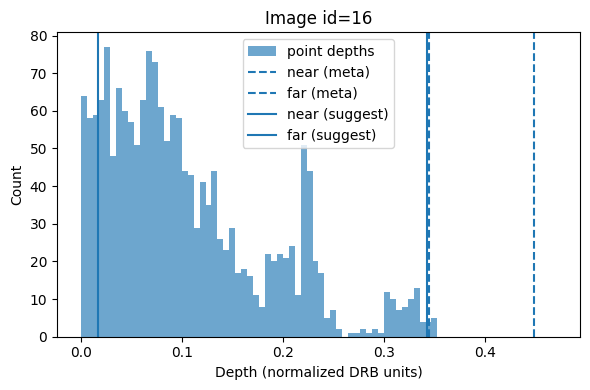

[rdf] p1=0.338 p2=0.344 p10=0.368 p90=0.443 p98=0.448 p99=0.449
[rdf near/far] 2/98 -> near=0.344, far=0.448
[rdf near/far] 10/90 -> near=0.368, far=0.443
[delta vs meta] |meta-2/98|: near=0.000e+00, far=0.000e+00
[delta vs meta] |meta-10/90|: near=2.404e-02, far=4.458e-03
[img_id=21] meta near=0.357, far=0.444, depth min=0.000, max=0.327, median=0.111
 coverage=0.0% | below=100.0% | above=0.0% | p5=0.012 p20=0.047 p80=0.196 p95=0.269
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.009, far=0.315 | tmin=0.009, tmax=2.627, p1=0.002, p99=0.305


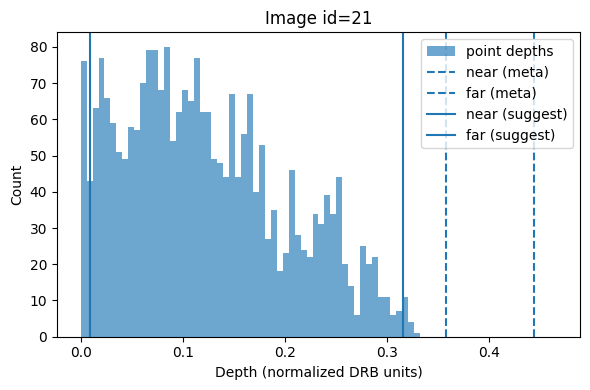

[rdf] p1=0.354 p2=0.357 p10=0.383 p90=0.441 p98=0.444 p99=0.444
[rdf near/far] 2/98 -> near=0.357, far=0.444
[rdf near/far] 10/90 -> near=0.383, far=0.441
[delta vs meta] |meta-2/98|: near=0.000e+00, far=0.000e+00
[delta vs meta] |meta-10/90|: near=2.531e-02, far=2.298e-03


In [21]:
# === Depth coverage vs. near/far in normalized DRB (lean, correct, reproducible) ===
# Minimal but sufficient fixes + AABB-based suggestions:
#  1) Correct image↔metadata mapping via mappings.txt (name→000123.pt).
#  2) Correct normalization via coordinates.pt (origin_drb, pose_scale_factor).
#  3) Re-derive ENU geodetic origin from camera centers (mean policy) so we don't pass lat/lon/h manually.
#  4) Quantitative diagnostics beyond histograms.
#  5) NEW: Global AABB + ray–AABB intersection and robust percentile fusion → suggested near/far per image.

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import pymap3d as pm
from typing import Dict, Tuple, Optional

# ---- PATHS (adjust DATA_ROOT if needed) ----
DATA_ROOT = Path("data/drz")
MODEL_PATH = DATA_ROOT / "model"                # COLMAP model dir (.bin or .txt)
OUT_DIR    = DATA_ROOT / "out/current"
META_DIR   = OUT_DIR / "train/metadata"        # per-image .pt files: 000000.pt, ...
COORDS_PT  = OUT_DIR / "coordinates.pt"        # has origin_drb, pose_scale_factor
MAPPINGS   = OUT_DIR / "mappings.txt"          # lines: "<image_name>,<000123>.pt"

DEVICE = "cpu"
FORWARD_IS_NORTH = False   # must match the flag used in your prepare step
HIST_BINS = 80
COVERAGE_WARN = 0.90
ORIGIN_POLICY = "mean"    # {"mean", "median", "first"}; should match your prep choice
SAMPLE_IDXS = [0, 5, 10, 15, 20]  # indices in mappings order

# AABB + suggestion policy
AABB_MARGIN_FRAC = 0.02   # expand AABB by 2% of diagonal
EPS_NEAR         = 1e-3   # minimal near in normalized units
MIN_THICK        = 0.02   # minimal (far - near) in normalized units
DELTA_FAR        = 0.01   # add-on margin above p99
P_LOW, P_HIGH    = 1.0, 99.0  # robust percentiles

# ---- Imports from your project ----
from data.colmap_utils import read_model, qvec2rotmat

# ---- Axis similarity (RDF -> DRB) ----
RDF_TO_DRB = np.array([
    [0., 1.,  0.],   # Down   = RDF_y
    [1., 0.,  0.],   # Right  = RDF_x
    [0., 0., -1.],   # Back   = -RDF_z
], dtype=np.float64)

# =========================
# Helpers
# =========================

def load_normalization_constants(coords_path: Path) -> Tuple[np.ndarray, float]:
    c = torch.load(coords_path, map_location="cpu")
    origin_drb = c["origin_drb"].double().numpy().reshape(3)
    pose_scale = float(c["pose_scale_factor"])
    return origin_drb, pose_scale


def ecef_to_enu_np(XYZ: np.ndarray, lat0: float, lon0: float, h0: float) -> np.ndarray:
    ell = pm.Ellipsoid.from_name('wgs84')
    XYZ = np.atleast_2d(XYZ)
    out = np.empty_like(XYZ)
    for i, (X, Y, Z) in enumerate(XYZ):
        e, n, u = pm.ecef2enu(X, Y, Z, lat0, lon0, h0, ell=ell)
        out[i] = [e, n, u]
    return out


def enu_to_drb_np(ENU: np.ndarray, forward_is_north: bool) -> np.ndarray:
    ENU = np.atleast_2d(ENU)
    z_sign = -1.0 if forward_is_north else 1.0
    D = -ENU[:, 2]
    R =  ENU[:, 0]
    B =  z_sign * ENU[:, 1]
    return np.stack([D, R, B], axis=1)


def geodetic_origin_from_images(images: Dict[int, object], policy: str = "mean") -> Tuple[float, float, float]:
    ell = pm.Ellipsoid.from_name('wgs84')
    lats, lons, hs = [], [], []
    for img in images.values():
        R = qvec2rotmat(img.qvec).astype(np.float64)
        t = img.tvec.reshape(3, 1).astype(np.float64)
        C = (-R.T @ t).reshape(3)
        lat, lon, h = pm.ecef2geodetic(C[0], C[1], C[2], ell=ell)
        lats.append(lat); lons.append(lon); hs.append(h)
    lats = np.array(lats); lons = np.array(lons); hs = np.array(hs)
    if policy == "first":
        return float(lats[0]), float(lons[0]), float(hs[0])
    if policy == "median":
        return float(np.median(lats)), float(np.median(lons)), float(np.median(hs))
    return float(np.mean(lats)), float(np.mean(lons)), float(np.mean(hs))


def world_points_to_norm_drb(points3D: Dict[int, object], lat0: float, lon0: float, h0: float,
                             origin_drb: np.ndarray, pose_scale: float) -> Tuple[np.ndarray, Dict[int, np.ndarray]]:
    pids = list(points3D.keys())
    XYZ_ecef = np.stack([points3D[pid].xyz for pid in pids], axis=0)
    ENU = ecef_to_enu_np(XYZ_ecef, lat0, lon0, h0)
    DRB = enu_to_drb_np(ENU, FORWARD_IS_NORTH)
    DRB_norm = (DRB - origin_drb[None, :]) / pose_scale
    if not np.all(np.isfinite(DRB_norm)):
        raise RuntimeError("Non-finite normalized 3D points.")
    pid2xyz = {pid: DRB_norm[i] for i, pid in enumerate(pids)}
    return DRB_norm, pid2xyz


def cam_rdf_to_norm_drb(img, lat0: float, lon0: float, h0: float,
                         origin_drb: np.ndarray, pose_scale: float) -> Tuple[np.ndarray, np.ndarray]:
    R_rdf = qvec2rotmat(img.qvec).astype(np.float64)
    t_rdf = img.tvec.reshape(3, 1).astype(np.float64)
    C_ecef = (-R_rdf.T @ t_rdf).reshape(1, 3)
    C_enu  = ecef_to_enu_np(C_ecef, lat0, lon0, h0)
    C_drb  = enu_to_drb_np(C_enu, FORWARD_IS_NORTH)[0]
    C_norm = (C_drb - origin_drb) / pose_scale
    R_drb  = RDF_TO_DRB @ R_rdf @ np.linalg.inv(RDF_TO_DRB)
    if not np.all(np.isfinite(C_norm)) or not np.all(np.isfinite(R_drb)):
        raise RuntimeError("Non-finite camera pose after transform.")
    return R_drb, C_norm

# ---------- AABB + ray utils ----------

def compute_scene_aabb(points_norm: np.ndarray, margin_frac: float = AABB_MARGIN_FRAC) -> Tuple[np.ndarray, np.ndarray]:
    pmin = points_norm.min(axis=0)
    pmax = points_norm.max(axis=0)
    diag = np.linalg.norm(pmax - pmin)
    pad  = margin_frac * diag
    return pmin - pad, pmax + pad


def forward_dir_world(R_w2c: np.ndarray) -> np.ndarray:
    # camera forward in camera coords is +Z; world dir = R_c2w @ [0,0,1]
    R_c2w = R_w2c.T
    d = R_c2w @ np.array([0.0, 0.0, 1.0])
    # normalize to unit length for stable t values
    n = np.linalg.norm(d)
    return d / (n + 1e-12)


def intersect_ray_aabb(C: np.ndarray, d: np.ndarray, bmin: np.ndarray, bmax: np.ndarray) -> Optional[Tuple[float, float]]:
    # Slab method; returns (tmin, tmax) if hit, else None
    tmin, tmax = -np.inf, np.inf
    for i in range(3):
        if abs(d[i]) < 1e-12:
            # Ray parallel to slab; reject if origin outside
            if C[i] < bmin[i] or C[i] > bmax[i]:
                return None
        else:
            inv = 1.0 / d[i]
            t1 = (bmin[i] - C[i]) * inv
            t2 = (bmax[i] - C[i]) * inv
            t_near = min(t1, t2)
            t_far  = max(t1, t2)
            tmin = max(tmin, t_near)
            tmax = min(tmax, t_far)
            if tmin > tmax:
                return None
    return tmin, tmax


def suggest_near_far_from(depths: np.ndarray, C: np.ndarray, R_w2c: np.ndarray,
                           aabb_min: np.ndarray, aabb_max: np.ndarray) -> Optional[Tuple[float, float, dict]]:
    d = forward_dir_world(R_w2c)
    hit = intersect_ray_aabb(C, d, aabb_min, aabb_max)
    if hit is None:
        return None
    tmin, tmax = hit
    # enforce forward only
    tmin = max(tmin, EPS_NEAR)
    tmax = max(tmax, tmin + MIN_THICK)

    # robust percentiles from sparse depths
    p_lo, p_hi = np.percentile(depths, [P_LOW, P_HIGH])
    near_s = max(EPS_NEAR, float(p_lo))
    far_s  = max(near_s + MIN_THICK, float(p_hi) + DELTA_FAR)

    near = max(tmin, near_s)
    far  = min(tmax, far_s)
    if far <= near:
        far = near + MIN_THICK
    details = {
        "tmin": float(tmin), "tmax": float(tmax),
        "p_low": float(p_lo), "p_high": float(p_hi),
        "near_s": float(near_s), "far_s": float(far_s)
    }
    return float(near), float(far), details

# ---------- Diagnostics & plotting ----------

def depth_diagnostics(depths: np.ndarray, near: float, far: float) -> None:
    p5, p20, p80, p95 = np.percentile(depths, [5, 20, 80, 95])
    inside = np.mean((depths >= near) & (depths <= far))
    below  = np.mean(depths < near)
    above  = np.mean(depths > far)
    print(f" coverage={inside*100:.1f}% | below={below*100:.1f}% | above={above*100:.1f}% | "
          f"p5={p5:.3f} p20={p20:.3f} p80={p80:.3f} p95={p95:.3f}")
    if inside < COVERAGE_WARN:
        print("[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.")


def render_depth_hist_for_image(img, img_meta: dict, pid2xyz_norm: Dict[int, np.ndarray],
                                lat0: float, lon0: float, h0: float,
                                origin_drb: np.ndarray, pose_scale: float,
                                aabb_min: np.ndarray, aabb_max: np.ndarray,
                                show_plot: bool = True) -> Optional[np.ndarray]:
    R_w2c, C_norm = cam_rdf_to_norm_drb(img, lat0, lon0, h0, origin_drb, pose_scale)
    t = (-R_w2c @ C_norm.reshape(3, 1)).reshape(3)

    pids = img.point3D_ids
    pids = pids[pids >= 0]
    if pids.size == 0:
        print(f"[{img.id:03d}] no associated 3D points.")
        return None

    pts = np.stack([pid2xyz_norm.get(pid) for pid in pids if pid in pid2xyz_norm], axis=0)
    if pts.size == 0:
        print(f"[{img.id:03d}] no normalized pts for this view.")
        return None

    cam_pts = (R_w2c @ pts.T + t.reshape(3,1)).T
    depths  = cam_pts[:, 2]
    depths  = depths[depths > 0]
    if depths.size == 0:
        print(f"[{img.id:03d}] no positive depths.")
        return None

    near_m, far_m = float(img_meta["near"]), float(img_meta["far"])  # metadata band (normalized)
    if not (np.isfinite(near_m) and np.isfinite(far_m)):
        raise RuntimeError("near/far are not finite in metadata.")
    if not (0 <= near_m < far_m):
        print(f"[WARN] weird near/far: near={near_m:.3f}, far={far_m:.3f}")

    print(f"[img_id={img.id}] meta near={near_m:.3f}, far={far_m:.3f}, "
          f"depth min={depths.min():.3f}, max={depths.max():.3f}, median={np.median(depths):.3f}")
    depth_diagnostics(depths, near_m, far_m)

    # Suggested near/far from AABB + percentiles
    sug = suggest_near_far_from(depths, C_norm, R_w2c, aabb_min, aabb_max)
    if sug is not None:
        near_sug, far_sug, info = sug
        print(f"[suggest] near={near_sug:.3f}, far={far_sug:.3f} | "
              f"tmin={info['tmin']:.3f}, tmax={info['tmax']:.3f}, "
              f"p{P_LOW:.0f}={info['p_low']:.3f}, p{P_HIGH:.0f}={info['p_high']:.3f}")
    else:
        near_sug, far_sug = None, None
        print("[suggest] ray does not intersect scene AABB — cannot suggest near/far.")

    if show_plot:
        plt.figure(figsize=(6,4))
        xmax = max(depths.max(), far_m if np.isfinite(far_m) else 0) * 1.05
        plt.hist(depths, bins=HIST_BINS, range=(0, xmax), alpha=0.65, label="point depths")
        plt.axvline(near_m, linestyle='--', label='near (meta)')
        plt.axvline(far_m,  linestyle='--', label='far (meta)')
        if near_sug is not None:
            plt.axvline(near_sug, linestyle='-', label='near (suggest)')
            plt.axvline(far_sug,  linestyle='-', label='far (suggest)')
        plt.title(f"Image id={img.id}")
        plt.xlabel("Depth (normalized DRB units)")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return depths

# =========================
# Load and run
# =========================
print("Loading COLMAP model…")
cameras, images, points3D = read_model(str(MODEL_PATH))
print(f"Loaded {len(points3D)} 3D points, {len(images)} images.")

# Normalization constants (no hardcoding)
origin_drb, pose_scale = load_normalization_constants(COORDS_PT)
print(f"origin_drb={origin_drb}, pose_scale={pose_scale:.6f}")

# ENU geodetic origin from camera centers (no manual lat/lon/h required)
LAT0, LON0, H0 = geodetic_origin_from_images(images, ORIGIN_POLICY)
print(f"ENU origin (policy={ORIGIN_POLICY}): lat0={LAT0:.9f}, lon0={LON0:.9f}, h0={H0:.3f}")

# Build name→index mapping from mappings.txt (ground truth linkage)
with MAPPINGS.open("r") as f:
    pairs = [line.strip().split(",") for line in f if line.strip()]
name_order = [nm for nm, fn in pairs]

# Convenience lookups
imgs_by_name = {img.name: img for img in images.values()}

# Normalize points once (for histograms, AABB, and DRB-based checks)
DRB_points, pid2xyz = world_points_to_norm_drb(points3D, LAT0, LON0, H0, origin_drb, pose_scale)

# Scene AABB in normalized space
AABB_MIN, AABB_MAX = compute_scene_aabb(DRB_points, AABB_MARGIN_FRAC)
print(f"AABB min={AABB_MIN}, max={AABB_MAX}")

# ---------- EXTRA: RDF-space recheck to diagnose mismatches ----------
# This reproduces _compute_near_far on-the-fly (in RDF, using raw COLMAP world coords),
# so we can compare with the metadata values (which were saved after dividing by pose_scale).

def rdf_depth_percentiles_for_image(img, points3D: Dict[int, object], low: float, high: float):
    R = np.asarray(qvec2rotmat(img.qvec), dtype=np.float64)
    t = np.asarray(img.tvec, dtype=np.float64).reshape(3, 1)
    if img.point3D_ids.size == 0:
        return None
    pids = img.point3D_ids
    pids = pids[pids >= 0]
    if pids.size == 0:
        return None
    XYZ = [np.asarray(points3D[pid].xyz, dtype=np.float64) for pid in pids if pid in points3D]
    if not XYZ:
        return None
    XYZ = np.stack(XYZ, axis=0)
    cam_pts = (R @ XYZ.T + t).T
    depths = cam_pts[:, 2]
    depths = depths[depths > 0]
    if depths.size == 0:
        return None
    n = float(np.percentile(depths, low)) / pose_scale
    f = float(np.percentile(depths, high)) / pose_scale
    return n, f, depths / pose_scale

# Run samples by MAPPINGS order (so SAMPLE_IDXS match metadata indices)
for k in SAMPLE_IDXS:
    if not (0 <= k < len(name_order)):
        print(f"[skip] SAMPLE_IDXS contains out-of-range index {k}")
        continue
    nm = name_order[k]
    img = imgs_by_name.get(nm, None)
    if img is None:
        print(f"[skip] image '{nm}' not found in COLMAP model")
        continue
    meta_path = META_DIR / f"{k:06d}.pt"
    if not meta_path.exists():
        print(f"[skip] {meta_path} not found")
        continue
    img_meta = torch.load(meta_path, map_location=DEVICE)

    # 1) DRB-based histogram + suggestions
    depths = render_depth_hist_for_image(
        img, img_meta, pid2xyz, LAT0, LON0, H0, origin_drb, pose_scale,
        AABB_MIN, AABB_MAX, show_plot=True
    )

    # 2) RDF replication of prep logic at {2,98} and {10,90}
    if depths is not None:
        rdf_2_98 = rdf_depth_percentiles_for_image(img, points3D, 2.0, 98.0)
        rdf_10_90 = rdf_depth_percentiles_for_image(img, points3D, 10.0, 90.0)
        if rdf_2_98 is not None:
            n298, f298, depths_rdf_norm = rdf_2_98
            p = np.percentile(depths_rdf_norm, [1,2,10,90,98,99])
            print(f"[rdf] p1={p[0]:.3f} p2={p[1]:.3f} p10={p[2]:.3f} p90={p[3]:.3f} p98={p[4]:.3f} p99={p[5]:.3f}")
            print(f"[rdf near/far] 2/98 -> near={n298:.3f}, far={f298:.3f}")
        if rdf_10_90 is not None:
            n1090, f1090, _ = rdf_10_90
            print(f"[rdf near/far] 10/90 -> near={n1090:.3f}, far={f1090:.3f}")

        # 3) Compare metadata vs RDF recompute
        near_m, far_m = float(img_meta["near"]), float(img_meta["far"]) # already normalized
        def delta(a,b):
            return abs(a-b)
        if rdf_2_98 is not None:
            print(f"[delta vs meta] |meta-2/98|: near={delta(near_m, n298):.3e}, far={delta(far_m, f298):.3e}")
        if rdf_10_90 is not None:
            print(f"[delta vs meta] |meta-10/90|: near={delta(near_m, n1090):.3e}, far={delta(far_m, f1090):.3e}")


Loading COLMAP model…
Loaded 183037 3D points, 249 images.
origin_drb=[-0.1021835   0.39724216  4.52259827], pose_scale=227.437721
ENU origin (policy=mean): lat0=51.548993636, lon0=7.373026041, h0=232.993
AABB min=[ 2.77813322e-03 -3.63094683e+00 -1.78437474e+00], max=[3.78333489 1.53465654 3.60878589]
[img_id=101] meta near=0.414, far=1.233, depth min=0.000, max=0.915, median=0.217
 coverage=18.6% | below=81.4% | above=0.0% | p5=0.023 p20=0.089 p80=0.399 p95=0.659
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.009, far=0.778 | tmin=0.009, tmax=1.321, p1=0.005, p99=0.768


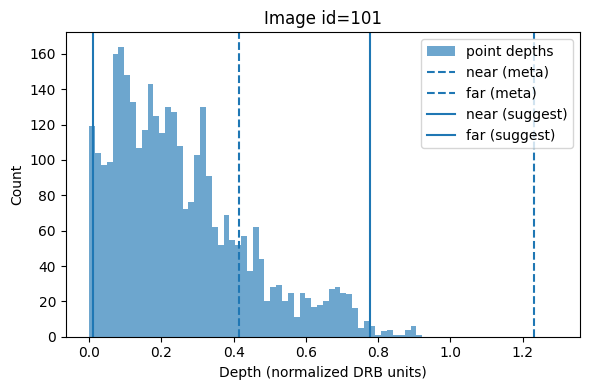

[img_id=106] meta near=0.397, far=1.249, depth min=0.000, max=0.847, median=0.175
 coverage=15.5% | below=84.5% | above=0.0% | p5=0.013 p20=0.054 p80=0.354 p95=0.563
[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.
[suggest] near=0.009, far=0.754 | tmin=0.009, tmax=1.322, p1=0.002, p99=0.744


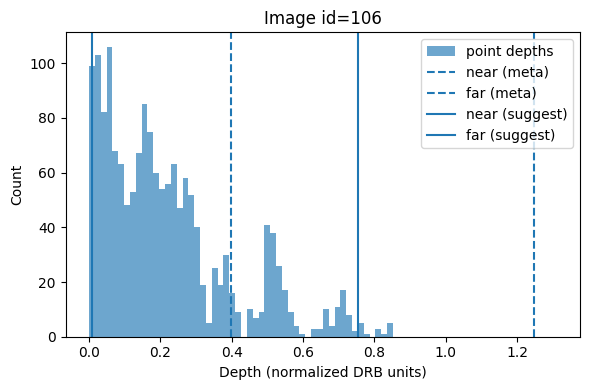

In [13]:
# === Depth coverage vs. near/far in normalized DRB (lean, correct, reproducible) ===
# Minimal but sufficient fixes + AABB-based suggestions:
#  1) Correct image↔metadata mapping via mappings.txt (name→000123.pt).
#  2) Correct normalization via coordinates.pt (origin_drb, pose_scale_factor).
#  3) Re-derive ENU geodetic origin from camera centers (mean policy) so we don't pass lat/lon/h manually.
#  4) Quantitative diagnostics beyond histograms.
#  5) NEW: Global AABB + ray–AABB intersection and robust percentile fusion → suggested near/far per image.

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import pymap3d as pm
from typing import Dict, Tuple, Optional

# ---- PATHS (adjust DATA_ROOT if needed) ----
DATA_ROOT = Path("data/drz")
MODEL_PATH = DATA_ROOT / "model"                # COLMAP model dir (.bin or .txt)
OUT_DIR    = DATA_ROOT / "out/current"
META_DIR   = OUT_DIR / "train/metadata"        # per-image .pt files: 000000.pt, ...
COORDS_PT  = OUT_DIR / "coordinates.pt"        # has origin_drb, pose_scale_factor
MAPPINGS   = OUT_DIR / "mappings.txt"          # lines: "<image_name>,<000123>.pt"

DEVICE = "cpu"
FORWARD_IS_NORTH = True   # must match the flag used in your prepare step
HIST_BINS = 80
COVERAGE_WARN = 0.90
ORIGIN_POLICY = "mean"    # {"mean", "median", "first"}; should match your prep choice
SAMPLE_IDXS = [100, 105]  # indices in mappings order

# AABB + suggestion policy
AABB_MARGIN_FRAC = 0.02   # expand AABB by 2% of diagonal
EPS_NEAR         = 1e-3   # minimal near in normalized units
MIN_THICK        = 0.02   # minimal (far - near) in normalized units
DELTA_FAR        = 0.01   # add-on margin above p99
P_LOW, P_HIGH    = 1.0, 99.0  # robust percentiles

# ---- Imports from your project ----
from data.colmap_utils import read_model, qvec2rotmat

# ---- Axis similarity (RDF -> DRB) ----
RDF_TO_DRB = np.array([
    [0., 1.,  0.],   # Down   = RDF_y
    [1., 0.,  0.],   # Right  = RDF_x
    [0., 0., -1.],   # Back   = -RDF_z
], dtype=np.float64)

# =========================
# Helpers
# =========================

def load_normalization_constants(coords_path: Path) -> Tuple[np.ndarray, float]:
    c = torch.load(coords_path, map_location="cpu")
    origin_drb = c["origin_drb"].double().numpy().reshape(3)
    pose_scale = float(c["pose_scale_factor"])
    return origin_drb, pose_scale


def ecef_to_enu_np(XYZ: np.ndarray, lat0: float, lon0: float, h0: float) -> np.ndarray:
    ell = pm.Ellipsoid.from_name('wgs84')
    XYZ = np.atleast_2d(XYZ)
    out = np.empty_like(XYZ)
    for i, (X, Y, Z) in enumerate(XYZ):
        e, n, u = pm.ecef2enu(X, Y, Z, lat0, lon0, h0, ell=ell)
        out[i] = [e, n, u]
    return out


def enu_to_drb_np(ENU: np.ndarray, forward_is_north: bool) -> np.ndarray:
    ENU = np.atleast_2d(ENU)
    z_sign = -1.0 if forward_is_north else 1.0
    D = -ENU[:, 2]
    R =  ENU[:, 0]
    B =  z_sign * ENU[:, 1]
    return np.stack([D, R, B], axis=1)


def geodetic_origin_from_images(images: Dict[int, object], policy: str = "mean") -> Tuple[float, float, float]:
    ell = pm.Ellipsoid.from_name('wgs84')
    lats, lons, hs = [], [], []
    for img in images.values():
        R = qvec2rotmat(img.qvec).astype(np.float64)
        t = img.tvec.reshape(3, 1).astype(np.float64)
        C = (-R.T @ t).reshape(3)
        lat, lon, h = pm.ecef2geodetic(C[0], C[1], C[2], ell=ell)
        lats.append(lat); lons.append(lon); hs.append(h)
    lats = np.array(lats); lons = np.array(lons); hs = np.array(hs)
    if policy == "first":
        return float(lats[0]), float(lons[0]), float(hs[0])
    if policy == "median":
        return float(np.median(lats)), float(np.median(lons)), float(np.median(hs))
    return float(np.mean(lats)), float(np.mean(lons)), float(np.mean(hs))


def world_points_to_norm_drb(points3D: Dict[int, object], lat0: float, lon0: float, h0: float,
                             origin_drb: np.ndarray, pose_scale: float) -> Tuple[np.ndarray, Dict[int, np.ndarray]]:
    pids = list(points3D.keys())
    XYZ_ecef = np.stack([points3D[pid].xyz for pid in pids], axis=0)
    ENU = ecef_to_enu_np(XYZ_ecef, lat0, lon0, h0)
    DRB = enu_to_drb_np(ENU, FORWARD_IS_NORTH)
    DRB_norm = (DRB - origin_drb[None, :]) / pose_scale
    if not np.all(np.isfinite(DRB_norm)):
        raise RuntimeError("Non-finite normalized 3D points.")
    pid2xyz = {pid: DRB_norm[i] for i, pid in enumerate(pids)}
    return DRB_norm, pid2xyz


def cam_rdf_to_norm_drb(img, lat0: float, lon0: float, h0: float,
                         origin_drb: np.ndarray, pose_scale: float) -> Tuple[np.ndarray, np.ndarray]:
    R_rdf = qvec2rotmat(img.qvec).astype(np.float64)
    t_rdf = img.tvec.reshape(3, 1).astype(np.float64)
    C_ecef = (-R_rdf.T @ t_rdf).reshape(1, 3)
    C_enu  = ecef_to_enu_np(C_ecef, lat0, lon0, h0)
    C_drb  = enu_to_drb_np(C_enu, FORWARD_IS_NORTH)[0]
    C_norm = (C_drb - origin_drb) / pose_scale
    R_drb  = RDF_TO_DRB @ R_rdf @ np.linalg.inv(RDF_TO_DRB)
    if not np.all(np.isfinite(C_norm)) or not np.all(np.isfinite(R_drb)):
        raise RuntimeError("Non-finite camera pose after transform.")
    return R_drb, C_norm

# ---------- AABB + ray utils ----------

def compute_scene_aabb(points_norm: np.ndarray, margin_frac: float = AABB_MARGIN_FRAC) -> Tuple[np.ndarray, np.ndarray]:
    pmin = points_norm.min(axis=0)
    pmax = points_norm.max(axis=0)
    diag = np.linalg.norm(pmax - pmin)
    pad  = margin_frac * diag
    return pmin - pad, pmax + pad


def forward_dir_world(R_w2c: np.ndarray) -> np.ndarray:
    # camera forward in camera coords is +Z; world dir = R_c2w @ [0,0,1]
    R_c2w = R_w2c.T
    d = R_c2w @ np.array([0.0, 0.0, 1.0])
    # normalize to unit length for stable t values
    n = np.linalg.norm(d)
    return d / (n + 1e-12)


def intersect_ray_aabb(C: np.ndarray, d: np.ndarray, bmin: np.ndarray, bmax: np.ndarray) -> Optional[Tuple[float, float]]:
    # Slab method; returns (tmin, tmax) if hit, else None
    tmin, tmax = -np.inf, np.inf
    for i in range(3):
        if abs(d[i]) < 1e-12:
            # Ray parallel to slab; reject if origin outside
            if C[i] < bmin[i] or C[i] > bmax[i]:
                return None
        else:
            inv = 1.0 / d[i]
            t1 = (bmin[i] - C[i]) * inv
            t2 = (bmax[i] - C[i]) * inv
            t_near = min(t1, t2)
            t_far  = max(t1, t2)
            tmin = max(tmin, t_near)
            tmax = min(tmax, t_far)
            if tmin > tmax:
                return None
    return tmin, tmax


def suggest_near_far_from(depths: np.ndarray, C: np.ndarray, R_w2c: np.ndarray,
                           aabb_min: np.ndarray, aabb_max: np.ndarray) -> Optional[Tuple[float, float, dict]]:
    d = forward_dir_world(R_w2c)
    hit = intersect_ray_aabb(C, d, aabb_min, aabb_max)
    if hit is None:
        return None
    tmin, tmax = hit
    # enforce forward only
    tmin = max(tmin, EPS_NEAR)
    tmax = max(tmax, tmin + MIN_THICK)

    # robust percentiles from sparse depths
    p_lo, p_hi = np.percentile(depths, [P_LOW, P_HIGH])
    near_s = max(EPS_NEAR, float(p_lo))
    far_s  = max(near_s + MIN_THICK, float(p_hi) + DELTA_FAR)

    near = max(tmin, near_s)
    far  = min(tmax, far_s)
    if far <= near:
        far = near + MIN_THICK
    details = {
        "tmin": float(tmin), "tmax": float(tmax),
        "p_low": float(p_lo), "p_high": float(p_hi),
        "near_s": float(near_s), "far_s": float(far_s)
    }
    return float(near), float(far), details

# ---------- Diagnostics & plotting ----------

def depth_diagnostics(depths: np.ndarray, near: float, far: float) -> None:
    p5, p20, p80, p95 = np.percentile(depths, [5, 20, 80, 95])
    inside = np.mean((depths >= near) & (depths <= far))
    below  = np.mean(depths < near)
    above  = np.mean(depths > far)
    print(f" coverage={inside*100:.1f}% | below={below*100:.1f}% | above={above*100:.1f}% | "
          f"p5={p5:.3f} p20={p20:.3f} p80={p80:.3f} p95={p95:.3f}")
    if inside < COVERAGE_WARN:
        print("[WARN] Low coverage inside [near,far]. Consider adjusting near/far computation policy.")


def render_depth_hist_for_image(img, img_meta: dict, pid2xyz_norm: Dict[int, np.ndarray],
                                lat0: float, lon0: float, h0: float,
                                origin_drb: np.ndarray, pose_scale: float,
                                aabb_min: np.ndarray, aabb_max: np.ndarray,
                                show_plot: bool = True) -> Optional[np.ndarray]:
    R_w2c, C_norm = cam_rdf_to_norm_drb(img, lat0, lon0, h0, origin_drb, pose_scale)
    t = (-R_w2c @ C_norm.reshape(3, 1)).reshape(3)

    pids = img.point3D_ids
    pids = pids[pids >= 0]
    if pids.size == 0:
        print(f"[{img.id:03d}] no associated 3D points.")
        return None

    pts = np.stack([pid2xyz_norm.get(pid) for pid in pids if pid in pid2xyz_norm], axis=0)
    if pts.size == 0:
        print(f"[{img.id:03d}] no normalized pts for this view.")
        return None

    cam_pts = (R_w2c @ pts.T + t.reshape(3,1)).T
    depths  = cam_pts[:, 2]
    depths  = depths[depths > 0]
    if depths.size == 0:
        print(f"[{img.id:03d}] no positive depths.")
        return None

    near_m, far_m = float(img_meta["near"]), float(img_meta["far"])  # metadata band (normalized)
    if not (np.isfinite(near_m) and np.isfinite(far_m)):
        raise RuntimeError("near/far are not finite in metadata.")
    if not (0 <= near_m < far_m):
        print(f"[WARN] weird near/far: near={near_m:.3f}, far={far_m:.3f}")

    print(f"[img_id={img.id}] meta near={near_m:.3f}, far={far_m:.3f}, "
          f"depth min={depths.min():.3f}, max={depths.max():.3f}, median={np.median(depths):.3f}")
    depth_diagnostics(depths, near_m, far_m)

    # Suggested near/far from AABB + percentiles
    sug = suggest_near_far_from(depths, C_norm, R_w2c, aabb_min, aabb_max)
    if sug is not None:
        near_sug, far_sug, info = sug
        print(f"[suggest] near={near_sug:.3f}, far={far_sug:.3f} | "
              f"tmin={info['tmin']:.3f}, tmax={info['tmax']:.3f}, "
              f"p{P_LOW:.0f}={info['p_low']:.3f}, p{P_HIGH:.0f}={info['p_high']:.3f}")
    else:
        near_sug, far_sug = None, None
        print("[suggest] ray does not intersect scene AABB — cannot suggest near/far.")

    if show_plot:
        plt.figure(figsize=(6,4))
        xmax = max(depths.max(), far_m if np.isfinite(far_m) else 0) * 1.05
        plt.hist(depths, bins=HIST_BINS, range=(0, xmax), alpha=0.65, label="point depths")
        plt.axvline(near_m, linestyle='--', label='near (meta)')
        plt.axvline(far_m,  linestyle='--', label='far (meta)')
        if near_sug is not None:
            plt.axvline(near_sug, linestyle='-', label='near (suggest)')
            plt.axvline(far_sug,  linestyle='-', label='far (suggest)')
        plt.title(f"Image id={img.id}")
        plt.xlabel("Depth (normalized DRB units)")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return depths

# =========================
# Load and run
# =========================
print("Loading COLMAP model…")
cameras, images, points3D = read_model(str(MODEL_PATH))
print(f"Loaded {len(points3D)} 3D points, {len(images)} images.")

# Normalization constants (no hardcoding)
origin_drb, pose_scale = load_normalization_constants(COORDS_PT)
print(f"origin_drb={origin_drb}, pose_scale={pose_scale:.6f}")

# ENU geodetic origin from camera centers (no manual lat/lon/h required)
LAT0, LON0, H0 = geodetic_origin_from_images(images, ORIGIN_POLICY)
print(f"ENU origin (policy={ORIGIN_POLICY}): lat0={LAT0:.9f}, lon0={LON0:.9f}, h0={H0:.3f}")

# Build name→index mapping from mappings.txt (ground truth linkage)
with MAPPINGS.open("r") as f:
    pairs = [line.strip().split(",") for line in f if line.strip()]
name_order = [nm for nm, fn in pairs]

# Convenience lookups
imgs_by_name = {img.name: img for img in images.values()}

# Normalize points once
DRB_points, pid2xyz = world_points_to_norm_drb(points3D, LAT0, LON0, H0, origin_drb, pose_scale)

# Scene AABB in normalized space
AABB_MIN, AABB_MAX = compute_scene_aabb(DRB_points, AABB_MARGIN_FRAC)
print(f"AABB min={AABB_MIN}, max={AABB_MAX}")

# Run samples by MAPPINGS order (so SAMPLE_IDXS match metadata indices)
for k in SAMPLE_IDXS:
    if not (0 <= k < len(name_order)):
        print(f"[skip] SAMPLE_IDXS contains out-of-range index {k}")
        continue
    nm = name_order[k]
    img = imgs_by_name.get(nm, None)
    if img is None:
        print(f"[skip] image '{nm}' not found in COLMAP model")
        continue
    meta_path = META_DIR / f"{k:06d}.pt"
    if not meta_path.exists():
        print(f"[skip] {meta_path} not found")
        continue
    img_meta = torch.load(meta_path, map_location=DEVICE)
    render_depth_hist_for_image(
        img, img_meta, pid2xyz, LAT0, LON0, H0, origin_drb, pose_scale,
        AABB_MIN, AABB_MAX, show_plot=True
    )


mean before: 0.36619171500205994 after: 0.15819445252418518


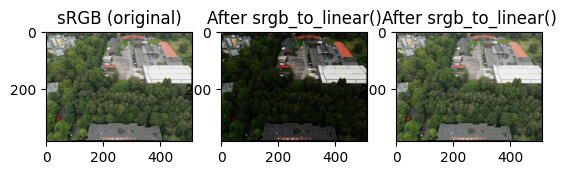

In [11]:

from common.utils import srgb_to_linear,linear_to_srgb
import matplotlib.pyplot as plt
from data.dataset import get_image_metadata

train_md,_= get_image_metadata('data/drz/out/new', .25)
md = train_md[170]
img = md.load_image().float() / 255.0
img_lin = srgb_to_linear(img)

print("mean before:", img.mean().item(), "after:", img_lin.mean().item())

plt.subplot(1,3,1); plt.imshow(img.numpy()); plt.title("sRGB (original)")
plt.subplot(1,3,2); plt.imshow(img_lin.numpy()); plt.title("After srgb_to_linear()")
plt.subplot(1,3,3); plt.imshow(linear_to_srgb(img_lin).numpy()); plt.title("After srgb_to_linear()")

plt.show()